In [2]:
import os, math, random, numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

print("TF:", tf.__version__)
SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

os.makedirs("checkpoints", exist_ok=True)
os.makedirs("results/gradcam", exist_ok=True)
os.makedirs("results/fft", exist_ok=True)

TF: 2.19.0


In [3]:
(x_train, _), (x_test, _) = keras.datasets.mnist.load_data()

x_train = (x_train.astype("float32") - 127.5) / 127.5
x_test  = (x_test.astype("float32") - 127.5) / 127.5

x_train = np.expand_dims(x_train, axis=-1)
x_test  = np.expand_dims(x_test, axis=-1)

BATCH_SIZE = 256
train_ds = tf.data.Dataset.from_tensor_slices(x_train).shuffle(60000).batch(BATCH_SIZE, drop_remainder=True)

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


### DCGAN model to generate 28×28 images.

In [4]:
LATENT_DIM = 100

def build_generator(latent_dim=LATENT_DIM):
    model = keras.Sequential(name="generator")
    model.add(layers.Input(shape=(latent_dim,)))

    model.add(layers.Dense(7*7*128, use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 128)))

    model.add(layers.Conv2DTranspose(64, kernel_size=4, strides=2, padding="same", use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(32, kernel_size=4, strides=2, padding="same", use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2D(1, kernel_size=3, padding="same", activation="tanh"))
    return model

def build_discriminator():
    model = keras.Sequential(name="discriminator")
    model.add(layers.Input(shape=(28, 28, 1)))

    model.add(layers.Conv2D(64, 4, strides=2, padding="same"))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, 4, strides=2, padding="same"))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))
    return model

In [7]:
bce = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def train_step(images, generator, discriminator, g_opt, d_opt):
    batch_size = tf.shape(images)[0]
    noise = tf.random.normal([batch_size, LATENT_DIM])

    with tf.GradientTape() as d_tape:
        fake = generator(noise, training=True)
        real_logits = discriminator(images, training=True)
        fake_logits = discriminator(fake, training=True)

        d_loss_real = bce(tf.ones_like(real_logits), real_logits)
        d_loss_fake = bce(tf.zeros_like(fake_logits), fake_logits)
        d_loss = d_loss_real + d_loss_fake

    d_grads = d_tape.gradient(d_loss, discriminator.trainable_variables)
    d_opt.apply_gradients(zip(d_grads, discriminator.trainable_variables))

    noise = tf.random.normal([batch_size, LATENT_DIM])
    with tf.GradientTape() as g_tape:
        fake = generator(noise, training=True)
        fake_logits = discriminator(fake, training=True)
        g_loss = bce(tf.ones_like(fake_logits), fake_logits)

    g_grads = g_tape.gradient(g_loss, generator.trainable_variables)
    g_opt.apply_gradients(zip(g_grads, generator.trainable_variables))

    return d_loss, g_loss

def sample_and_plot(generator, n=16, title="samples"):
    noise = tf.random.normal([n, LATENT_DIM])
    imgs = generator(noise, training=False).numpy()
    imgs = (imgs + 1.0) / 2.0

    plt.figure(figsize=(4,4))
    for i in range(n):
        plt.subplot(4,4,i+1)
        plt.imshow(imgs[i,:,:,0], cmap="gray")
        plt.axis("off")
    plt.suptitle(title)
    plt.show()

def train_dcgan_instance(instance_id, epochs=5, seed=0):
    tf.random.set_seed(seed)
    np.random.seed(seed)

    gen = build_generator()
    disc = build_discriminator()

    g_opt = keras.optimizers.Adam(1e-4, beta_1=0.5)
    d_opt = keras.optimizers.Adam(1e-4, beta_1=0.5)

    for ep in range(1, epochs+1):
        d_losses, g_losses = [], []
        for batch in train_ds:
            d_loss, g_loss = train_step(batch, gen, disc, g_opt, d_opt)
            d_losses.append(d_loss.numpy())
            g_losses.append(g_loss.numpy())

        print(f"[GAN {instance_id}] Epoch {ep}/{epochs} | D: {np.mean(d_losses):.4f} | G: {np.mean(g_losses):.4f}")

        if ep == 1 or ep == epochs:
            sample_and_plot(gen, title=f"GAN {instance_id} epoch {ep}")

    gen.save_weights(f"checkpoints/gen_{instance_id}.weights.h5")
    return gen

 We just trained one GAN instance. Now we will call it multiple times with different seeds to train more GAN instances.

[GAN 0] Epoch 1/5 | D: 0.9895 | G: 1.0057


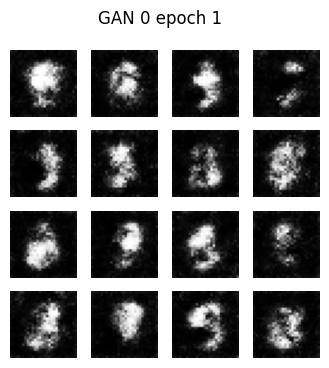

[GAN 0] Epoch 2/5 | D: 1.3014 | G: 0.7438
[GAN 0] Epoch 3/5 | D: 1.3448 | G: 0.7325
[GAN 0] Epoch 4/5 | D: 1.3338 | G: 0.7391
[GAN 0] Epoch 5/5 | D: 1.3138 | G: 0.7651


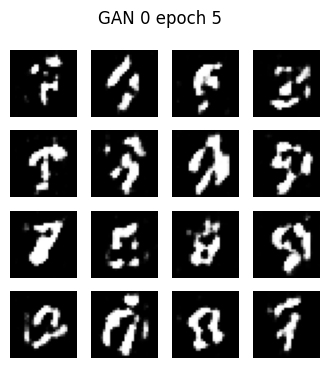

[GAN 1] Epoch 1/5 | D: 1.2970 | G: 0.6817


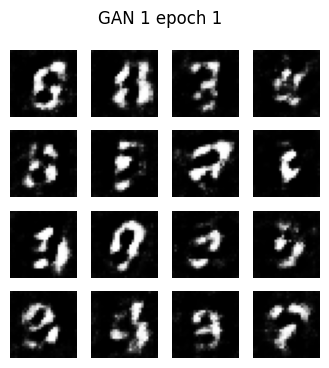

[GAN 1] Epoch 2/5 | D: 1.3538 | G: 0.7247
[GAN 1] Epoch 3/5 | D: 1.3339 | G: 0.7503
[GAN 1] Epoch 4/5 | D: 1.2907 | G: 0.7878
[GAN 1] Epoch 5/5 | D: 1.2376 | G: 0.8403


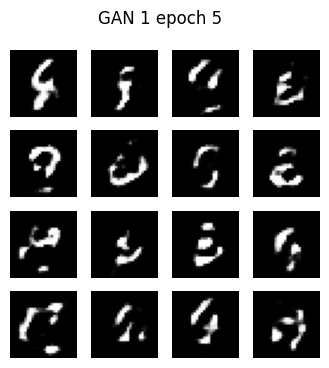

[GAN 2] Epoch 1/5 | D: 1.2883 | G: 0.6921


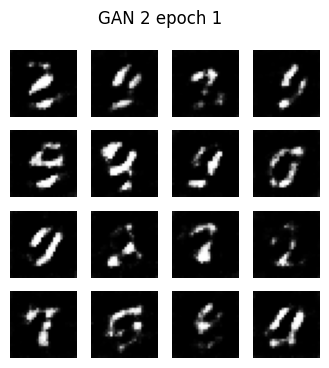

[GAN 2] Epoch 2/5 | D: 1.3511 | G: 0.7234
[GAN 2] Epoch 3/5 | D: 1.3292 | G: 0.7589
[GAN 2] Epoch 4/5 | D: 1.2705 | G: 0.8013
[GAN 2] Epoch 5/5 | D: 1.2255 | G: 0.8517


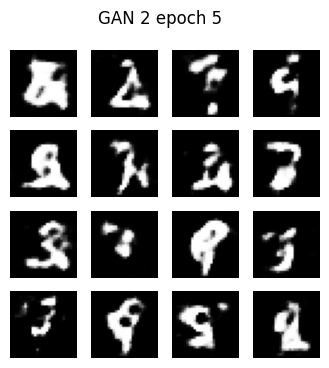

In [8]:
GAN_EPOCHS = 5

gens = []
seeds = [11, 22, 33]

for i, s in enumerate(seeds):
    gen = train_dcgan_instance(instance_id=i, epochs=GAN_EPOCHS, seed=s)
    gens.append(gen)

 We’ll create fake images from GAN-0 and GAN-1 for training

In [9]:
def generate_fake_images(generator, n):
    noise = tf.random.normal([n, LATENT_DIM])
    imgs = generator(noise, training=False).numpy()
    return imgs

def make_classifier_data(n_real=20000, n_fake=20000, train_gan_ids=(0,1)):
    idx = np.random.choice(len(x_train), size=n_real, replace=False)
    real = x_train[idx]
    y_real = np.zeros((n_real, 1), dtype=np.float32)

    per_gan = n_fake // len(train_gan_ids)
    fake_list = []
    for gid in train_gan_ids:
        fake_list.append(generate_fake_images(gens[gid], per_gan))
    fake = np.concatenate(fake_list, axis=0)
    y_fake = np.ones((fake.shape[0], 1), dtype=np.float32)

    X = np.concatenate([real, fake], axis=0)
    y = np.concatenate([y_real, y_fake], axis=0)

    p = np.random.permutation(len(X))
    X, y = X[p], y[p]

    return X, y

X_clf, y_clf = make_classifier_data(n_real=20000, n_fake=20000, train_gan_ids=(0,1))
print(X_clf.shape, y_clf.shape)

(40000, 28, 28, 1) (40000, 1)


This is a CNN classifier.

In [10]:
def build_classifier():
    inputs = layers.Input(shape=(28,28,1))
    x = layers.Conv2D(32, 3, activation="relu")(inputs)
    x = layers.MaxPooling2D()(x)

    x = layers.Conv2D(64, 3, activation="relu", name="last_conv")(x)
    x = layers.MaxPooling2D()(x)

    x = layers.Flatten()(x)
    x = layers.Dense(128, activation="relu")(x)
    logits = layers.Dense(1)(x)

    model = keras.Model(inputs, logits, name="gan_classifier")
    return model

clf = build_classifier()
clf.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy(threshold=0.0)]
)

history = clf.fit(
    X_clf, y_clf,
    validation_split=0.2,
    epochs=5,
    batch_size=256,
    verbose=1
)

Epoch 1/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - binary_accuracy: 0.7812 - loss: 0.4332 - val_binary_accuracy: 0.9941 - val_loss: 0.0291
Epoch 2/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - binary_accuracy: 0.9945 - loss: 0.0264 - val_binary_accuracy: 0.9974 - val_loss: 0.0108
Epoch 3/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - binary_accuracy: 0.9970 - loss: 0.0112 - val_binary_accuracy: 0.9980 - val_loss: 0.0068
Epoch 4/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - binary_accuracy: 0.9988 - loss: 0.0066 - val_binary_accuracy: 0.9985 - val_loss: 0.0053
Epoch 5/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - binary_accuracy: 0.9992 - loss: 0.0044 - val_binary_accuracy: 0.9977 - val_loss: 0.0076


Grad-CAM implementation. This returns a heatmap for one image.

In [11]:
def gradcam_heatmap(model, img, last_conv_name="last_conv"):
    img = tf.convert_to_tensor(img[None, ...], dtype=tf.float32)

    last_conv = model.get_layer(last_conv_name).output
    grad_model = tf.keras.Model([model.inputs], [last_conv, model.output])

    with tf.GradientTape() as tape:
        conv_out, logits = grad_model(img)
        loss = logits[:, 0]

    grads = tape.gradient(loss, conv_out)
    pooled = tf.reduce_mean(grads, axis=(0,1,2))

    conv_out = conv_out[0]
    heatmap = tf.reduce_sum(conv_out * pooled, axis=-1)

    heatmap = tf.nn.relu(heatmap)
    heatmap = heatmap / (tf.reduce_max(heatmap) + 1e-8)
    heatmap = heatmap.numpy()

    heatmap = tf.image.resize(heatmap[..., None], (28,28)).numpy()[:,:,0]
    return heatmap

def show_gradcam(img, heatmap, title="Grad-CAM"):
    img01 = (img[:,:,0] + 1.0)/2.0
    plt.figure(figsize=(8,3))

    plt.subplot(1,3,1)
    plt.imshow(img01, cmap="gray")
    plt.title("Image")
    plt.axis("off")

    plt.subplot(1,3,2)
    plt.imshow(heatmap, cmap="jet")
    plt.title("Heatmap")
    plt.axis("off")

    plt.subplot(1,3,3)
    plt.imshow(img01, cmap="gray")
    plt.imshow(heatmap, cmap="jet", alpha=0.45)
    plt.title("Overlay")
    plt.axis("off")

    plt.suptitle(title)
    plt.show()

/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor_520']]
Received: inputs=['Tensor(shape=(1, 28, 28, 1))']
  warnings.warn(msg)


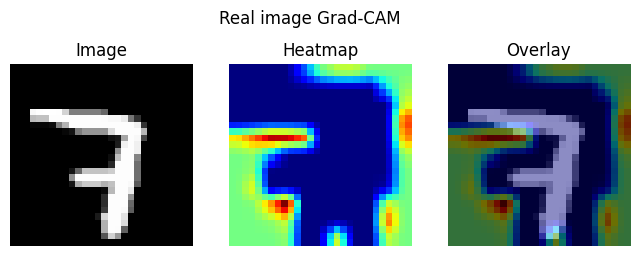

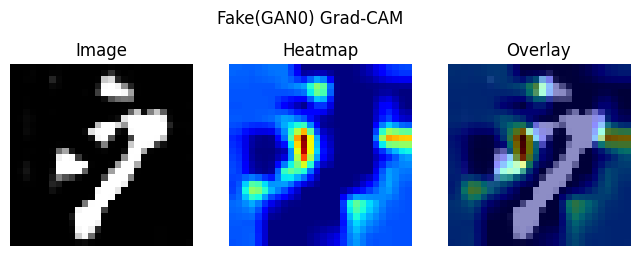

In [12]:
real_img = x_test[np.random.randint(len(x_test))]
real_hm = gradcam_heatmap(clf, real_img)
show_gradcam(real_img, real_hm, title="Real image Grad-CAM")

fake0 = generate_fake_images(gens[0], 1)[0]
fake0_hm = gradcam_heatmap(clf, fake0)
show_gradcam(fake0, fake0_hm, title="Fake(GAN0) Grad-CAM")

Cosine similarity between mean Grad-CAM heatmaps:
[[1.         0.98115915 0.94472057]
 [0.98115915 1.         0.94835311]
 [0.94472057 0.94835311 0.99999988]]


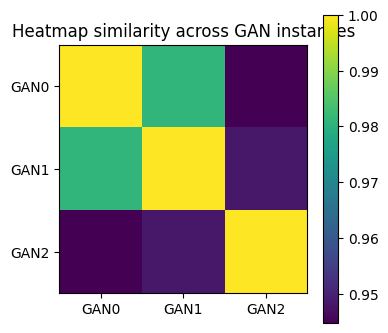

In [13]:
def cosine_sim(a, b, eps=1e-8):
    a = a.flatten()
    b = b.flatten()
    return float(np.dot(a,b) / (np.linalg.norm(a)*np.linalg.norm(b) + eps))

def mean_heatmap_for_gan(gid, n=200):
    fakes = generate_fake_images(gens[gid], n)
    hms = [gradcam_heatmap(clf, fakes[i]) for i in range(n)]
    return np.mean(hms, axis=0)

mean_hms = []
for gid in range(len(gens)):
    hm = mean_heatmap_for_gan(gid, n=200)
    mean_hms.append(hm)

G = len(gens)
sim = np.zeros((G,G))
for i in range(G):
    for j in range(G):
        sim[i,j] = cosine_sim(mean_hms[i], mean_hms[j])

print("Cosine similarity between mean Grad-CAM heatmaps:")
print(sim)

plt.figure(figsize=(4,4))
plt.imshow(sim, cmap="viridis")
plt.colorbar()
plt.title("Heatmap similarity across GAN instances")
plt.xticks(range(G), [f"GAN{i}" for i in range(G)])
plt.yticks(range(G), [f"GAN{i}" for i in range(G)])
plt.show()

In [14]:
def fft_power_spectrum(img):
    x = img[:,:,0]
    x = (x + 1.0) / 2.0
    f = np.fft.fft2(x)
    fshift = np.fft.fftshift(f)
    power = np.log(1.0 + np.abs(fshift)**2)
    return power

def mean_spectrum_real(n=2000):
    idx = np.random.choice(len(x_test), size=n, replace=False)
    specs = [fft_power_spectrum(x_test[i]) for i in idx]
    return np.mean(specs, axis=0)

def mean_spectrum_fake(gid, n=2000):
    fakes = generate_fake_images(gens[gid], n)
    specs = [fft_power_spectrum(fakes[i]) for i in range(n)]
    return np.mean(specs, axis=0)

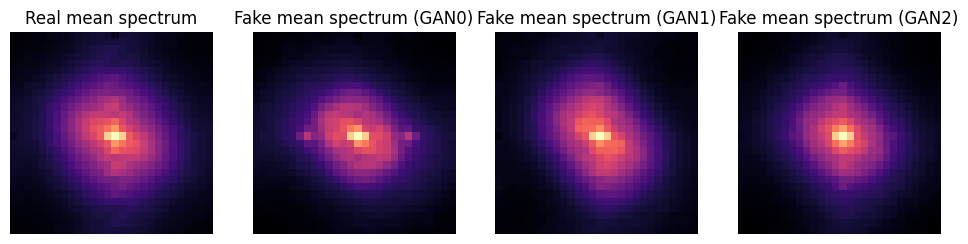

In [15]:
spec_real = mean_spectrum_real(n=1000)

plt.figure(figsize=(12,3))
plt.subplot(1,4,1)
plt.imshow(spec_real, cmap="magma")
plt.title("Real mean spectrum")
plt.axis("off")

for k,gid in enumerate(range(len(gens))):
    spec_fake = mean_spectrum_fake(gid, n=1000)
    plt.subplot(1,4,k+2)
    plt.imshow(spec_fake, cmap="magma")
    plt.title(f"Fake mean spectrum (GAN{gid})")
    plt.axis("off")

plt.show()